# hana_ml Clustering Algorithms

Author: SAP TI HA DB ML China

hana_ml provides the following clustering functions:

      - hana_ml.algorithms.pal.clustering.AffinityPropagation
      - hana_ml.algorithms.pal.clustering.AgglomerateHierarchicalClustering
      - hana_ml.algorithms.pal.clustering.DBSCAN
      - hana_ml.algorithms.pal.clustering.KMeans
      - hana_ml.algorithms.pal.clustering.KMedians
      - hana_ml.algorithms.pal.clustering.KMedoids
      - hana_ml.algorithms.pal.mixture.GaussianMixture
      - hana_ml.algorithms.pal.som.SOM

We also provide a unified clustering function to invoke the following function:    

      - 'AgglomerateHierarchicalClustering'
      - 'DBSCAN'
      - 'gaussianmixture'
      - 'AcceleratedKMeans'
      - 'KMeans'
      - 'KMedians'
      - 'KMedoids'
      - 'SOM'
      
In the following sections, we will use a 2D random data to call clustering algorithms and unified clustering function. 

## HANA Connection

First, create a connetion to SAP HANA. To create a such connection, a config file, config/e2edata.ini is used to control the connection parameters.A sample section in the config file is shown below which includes HANA url, port, user and password information.<br>

###################<br>

[hana]<br>
url=host-url<br>
user=username<br>
passwd=userpassword<br>
port=3xx15<br>

###################<br>

In [68]:
from hana_ml.dataframe import ConnectionContext
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = ConnectionContext(url, port, user, pwd)
connection_context.get_current_schema()

'PAL_USER'

## Dataset - Random 2D Samples

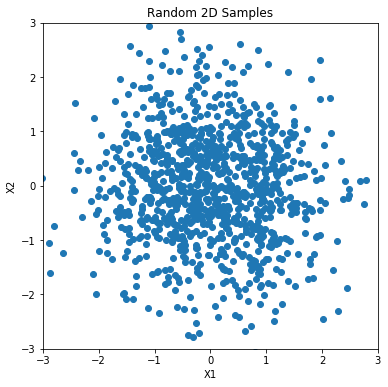

In [71]:
import pandas as pd
import numpy as np
from hana_ml.dataframe import create_dataframe_from_pandas
import matplotlib.pyplot as plt

n_samples = 1000
df = pd.DataFrame(np.random.randn(n_samples,2))
df.columns = ['X1', 'X2']

df_clustering = create_dataframe_from_pandas(connection_context=connection_context, pandas_df=df, table_name='TBL', force=True, replace=True)
df_clustering = df_clustering.add_id('ID')

# Draw the dataset
plt.figure(figsize=(6,6))
X1 = df_clustering.collect()[["X1"]]
X2 = df_clustering.collect()[["X2"]]
plt.scatter(X1, X2)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Random 2D Samples')
plt.show()

### Invoke the Clustering Algorithms and Visualize the Results

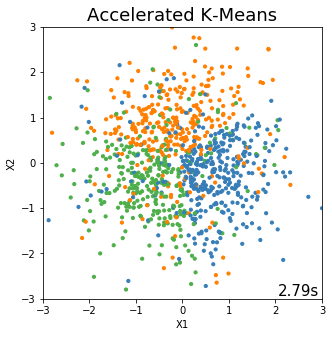

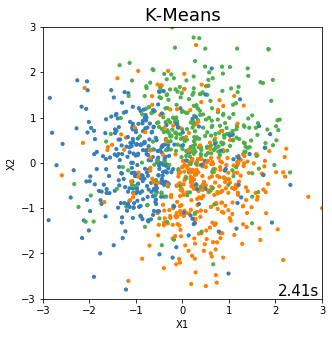

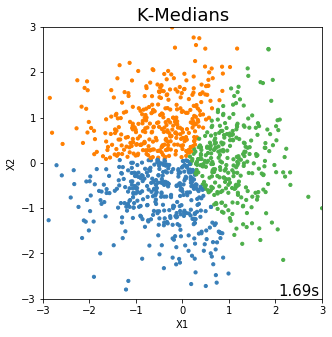

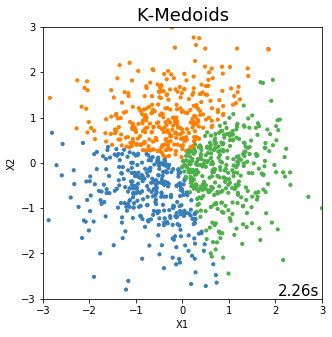

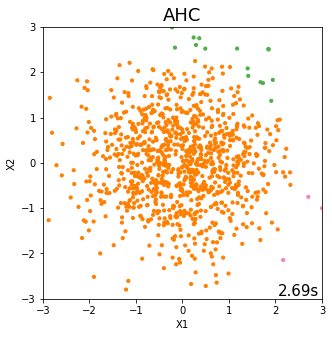

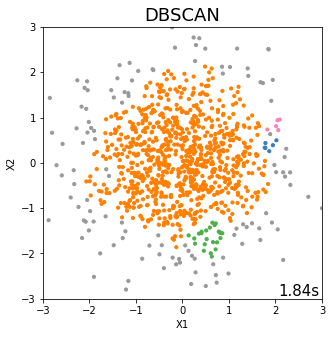

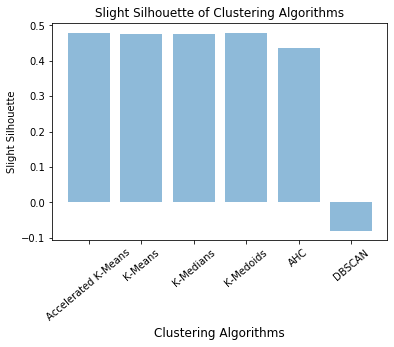

In [54]:
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hana_ml.algorithms.pal.clustering import AffinityPropagation, AgglomerateHierarchicalClustering, DBSCAN, KMeans, KMedians, KMedoids
from hana_ml.algorithms.pal.clustering import SlightSilhouette
import matplotlib.pyplot as plt

df_clustering = connection_context.table('RAM_TBL')
df_clustering = df_clustering.add_id('ID')

k_means = KMeans(n_clusters = 3)
acc_k_means = KMeans(n_clusters = 3, accelerated=True)
k_medians = KMedians(n_clusters = 3)
k_medoids = KMedoids(n_clusters = 3)
ahc = AgglomerateHierarchicalClustering(n_clusters = 3)
dbscan = DBSCAN()
agg = AgglomerateHierarchicalClustering(n_clusters = 3)


clustering_algorithms = ( 
    ('Accelerated K-Means', acc_k_means),
    ('K-Means', k_means),
    ('K-Medians', k_medians),
    ('K-Medoids', k_medoids),
    ('AHC', ahc),
    ('DBSCAN', dbscan))

X1 = df_clustering.collect()[["X1"]]
X2 = df_clustering.collect()[["X2"]]
ss_array = list()

for name, algorithm in clustering_algorithms:
    
    # Invoke the algorithm and record the caculation time
    t0 = time.time()  
    algorithm.fit(data=df_clustering, key = "ID")
    t1 = time.time()
    y = algorithm.labels_.collect()[["CLUSTER_ID"]].astype(np.int)  
    
    # obtain the SlightSilhouette of each algorithm 
    result = algorithm.labels_.select("ID", "CLUSTER_ID").rename_columns(["ID_R", "CLUSTER_ID"])    
    data_ss = df_clustering.join(result, condition="ID = ID_R")
    ss = SlightSilhouette(data_ss, label = "CLUSTER_ID", features = ["X1", "X2"]) 
    ss_array.append(ss.collect()['VALIDATE_VALUE'][0].astype(np.float))
    ss = None
    
    # plot the scatter figure and each cluster is colour with different colors
    plt.figure(figsize=(5,5))
    plt.title(name, size=18)
    m = {-1: '#999999', 0:'#377eb8',1:'#ff7f00',2:'#4daf4a', 3: '#f781bf', 4: '#a65628', 5:'#984ea3', 6: '#e41a1c'}

    if name == 'HierarchicalClustering':
        colors = list(map(lambda x:m[x-1], y["CLUSTER_ID"]))
    else:
        colors = list(map(lambda x:m[x], y["CLUSTER_ID"]))
        
    plot_num =0     
    plt.scatter(X1, X2, s=10, color=colors)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
            transform=plt.gca().transAxes, size=15,
            horizontalalignment='right')
    plot_num += 1
    colors = None
    plt.show()

# plot the Slight Silhouette figure of algorithms
names = ('Accelerated K-Means', 'K-Means',  'K-Medians', 'K-Medoids', 'AHC', 'DBSCAN')
y_pos = np.arange(len(names))
plt.bar(y_pos, ss_array, align='center', alpha=0.5)
plt.xticks(y_pos, names , rotation=40)
plt.xlabel('Clustering Algorithms', size =12)
plt.ylabel('Slight Silhouette')
plt.title('Slight Silhouette of Clustering Algorithms')
plt.show()

### Invoke the Unified Clustering and Visualize the Results

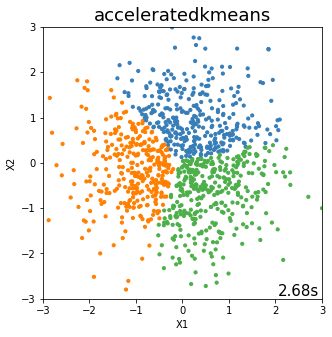

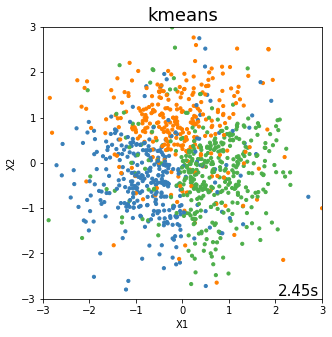

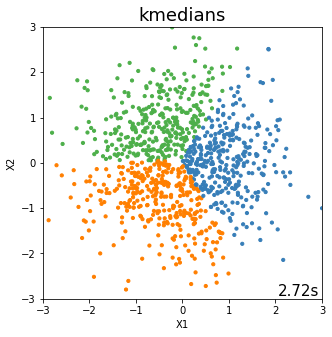

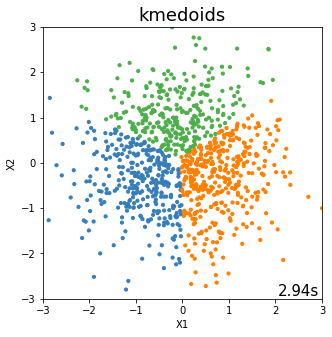

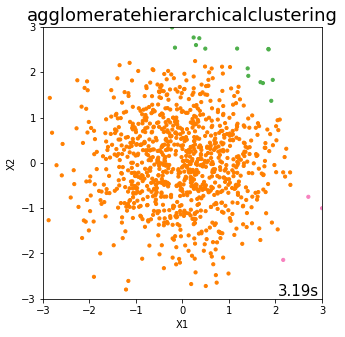

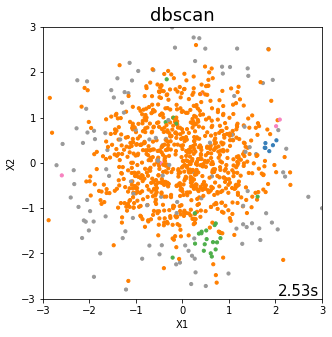

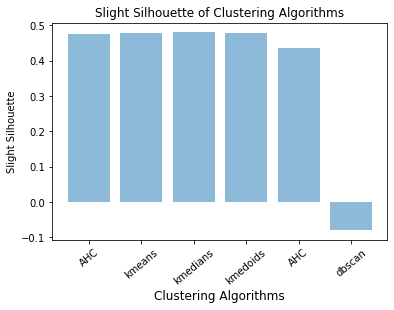

In [57]:
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from hana_ml.algorithms.pal.unified_clustering import UnifiedClustering

df_clustering = connection_context.table('RAM_TBL')
df_clustering = df_clustering.add_id('ID')

param_simple =dict(n_clusters =3)
clustering_algorithms =  {'acceleratedkmeans' : param_simple,
                          'kmeans' : param_simple,
                          'kmedians' : param_simple,
                          'kmedoids' : param_simple,       
                          'agglomeratehierarchicalclustering' : param_simple, 
                          'dbscan' : dict()                             
                         }

X1 = df_clustering.collect()[["X1"]]
X2 = df_clustering.collect()[["X2"]]
ss_array = list()

for name in clustering_algorithms:

    param=clustering_algorithms[name]
    uc_algorithm =  UnifiedClustering(func=name, **param)
    
    # Invoke the algorithm and record the caculation time
    t0 = time.time()  
    uc_algorithm.fit(data=df_clustering, key = "ID")
    t1 = time.time()
    y = uc_algorithm.labels_.collect()[["CLUSTER_ID"]].astype(np.int)    
        
    # obtain the SlightSilhouette of each algorithm 
    result = uc_algorithm.labels_.select("ID", "CLUSTER_ID").rename_columns(["ID_R", "CLUSTER_ID"])    
    
    data_ss = df_clustering.join(result, condition="ID = ID_R")
    ss = SlightSilhouette(data_ss, label = "CLUSTER_ID", features = ["X1", "X2"]) 
    ss_array.append(ss.collect()['VALIDATE_VALUE'][0].astype(np.float))
    ss = None
    
    # plot the scatter figure and each cluster is colour with different colors
    plt.figure(figsize=(5,5))
    plt.title(name, size=18)
    m = {-1: '#999999', 0:'#377eb8',1:'#ff7f00',2:'#4daf4a', 3: '#f781bf', 4: '#a65628', 5:'#984ea3', 6: '#e41a1c'}

    colors = list(map(lambda x:m[x], y["CLUSTER_ID"]))
    
    plot_num =0  
    plt.scatter(X1, X2, s=10, color=colors)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
            transform=plt.gca().transAxes, size=15,
            horizontalalignment='right')
    plot_num += 1
    colors = None
    plt.show()

# plot the Slight Silhouette figure of algorithms
names=[]
for name in clustering_algorithms:
    names.append(name)
names[0]='AHC'

y_pos = np.arange(len(names))
names[4]='AHC'
plt.bar(y_pos, ss_array, align='center', alpha=0.5)
plt.xticks(y_pos, names , rotation=40)
plt.xlabel('Clustering Algorithms', size =12)
plt.ylabel('Slight Silhouette')
plt.title('Slight Silhouette of Clustering Algorithms')
plt.show()

## Close the Connection

In [65]:
cursor = connection_context.connection.cursor()
try:
    drop_sql = "DROP TABLE TBL"
    cursor.execute(drop_sql)
finally:
    cursor.close()
connection_context.connection.commit()
connection_context.close()